In [19]:
from fastai.vision.all import *

In [20]:
# path to folder with subfolders of each image class
path = Path('/home/nick/Downloads/imagewoof2-320/train')

In [21]:
# a dict to remake imagenet names to well knowen names
label_remap_dict = {'n02086240':'Shih-Tzu',
                'n02087394':'Rhodesian_ridgeback',
                'n02088364':'beagle',
                'n02089973':'English_foxhound',
                'n02093754':'Border_terrier',
                'n02096294':'Australian_terrier',
                'n02099601':'golden_retriever',
                'n02105641':'Old_English_sheepdog',
                'n02111889':'Samoyed',
                'n02115641':'dingo'}

In [22]:
# rename folders to well knowen names
for folder in path.glob('n02*'):
    class_name = label_remap_dict[folder.name]
    folder.rename(path/class_name)

In [3]:
# this is the number of images on your GPU at once, lower it if you are getting CUDA memory erros
batch_size = 30
# idealy this would be the native size of your imagey, however if you are getting CUDA memory erros try lowering it
img_size = 320

In [4]:
# setup trasnforms
item_tfms = [Resize(img_size)]
batch_tfms = [Normalize.from_stats(*imagenet_stats),
            *aug_transforms(size=img_size)]
# https://docs.fast.ai/vision.augment.html#aug_transforms

In [24]:
type(aug_transforms)

function

In [5]:
# build a DataLoader
data = ImageDataLoaders.from_folder(path, train=".", valid_pct=0.2,splitter=RandomSplitter(seed=42),
                                    bs=batch_size,
                                    item_tfms=item_tfms,
                                    batch_tfms=batch_tfms
                                   )

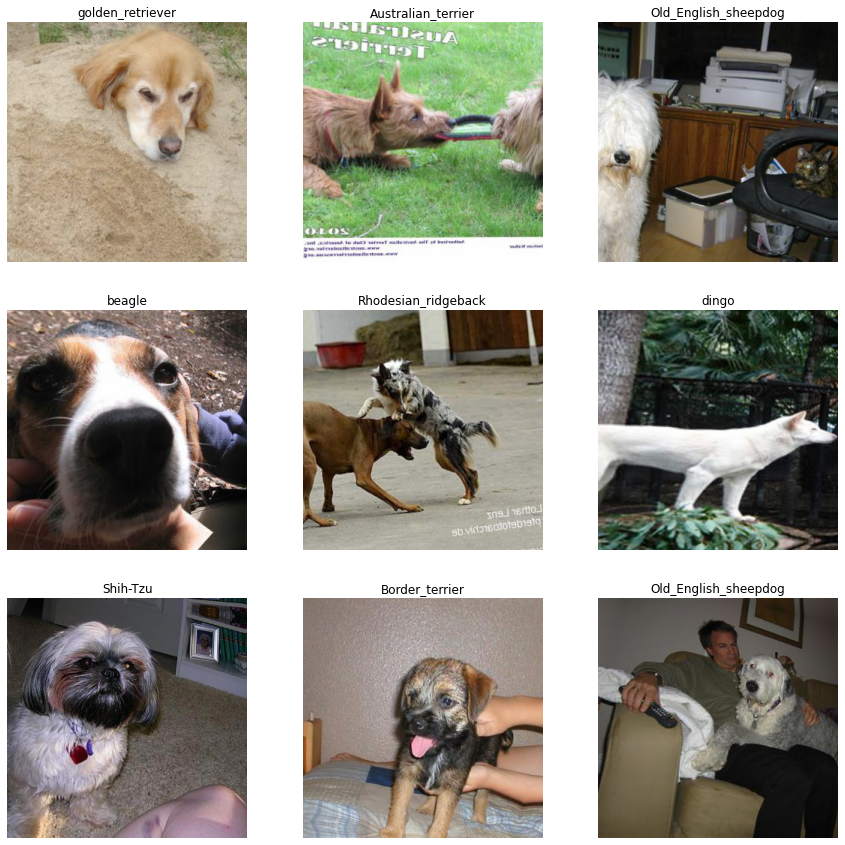

In [8]:
# show some data
data.show_batch(max_n = 9, figsize = (15,15))

In [12]:
# export your calsses to disk
np.savetxt(path/'classes.csv', np.array(data.vocab), fmt='%s')

In [13]:
# setup a fastai learner
learn = cnn_learner(data, resnet18, metrics=error_rate).to_fp16()

epoch,train_loss,valid_loss,error_rate,time
0,0.519025,0.204533,0.064266,00:16


Better model found at epoch 0 with error_rate value: 0.06426592171192169.


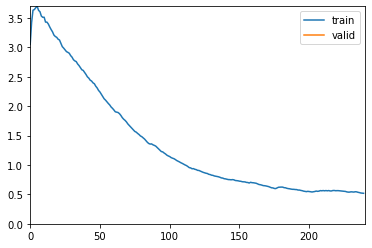

epoch,train_loss,valid_loss,error_rate,time
0,0.369242,0.252492,0.070360,00:22
1,0.299927,0.215611,0.068144,00:21
2,0.181806,0.186896,0.057618,00:21


Better model found at epoch 0 with error_rate value: 0.07036010175943375.


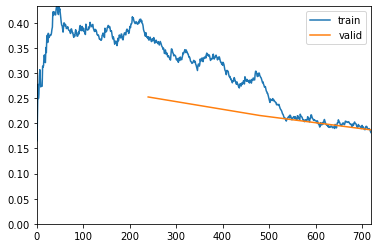

Better model found at epoch 1 with error_rate value: 0.06814403831958771.
Better model found at epoch 2 with error_rate value: 0.05761772021651268.


In [14]:
# train your model, it should take 1-5m mins depending on your hardware, expected error is 5-7%
learn.fine_tune(3,cbs = [ShowGraphCallback(),
                         SaveModelCallback(monitor='error_rate',with_opt=True, fname='quick_model')])

In [15]:
# reload the best model
learn.load('quick_model')
# save it to disk
learn.export('models/quick_model.pkl')

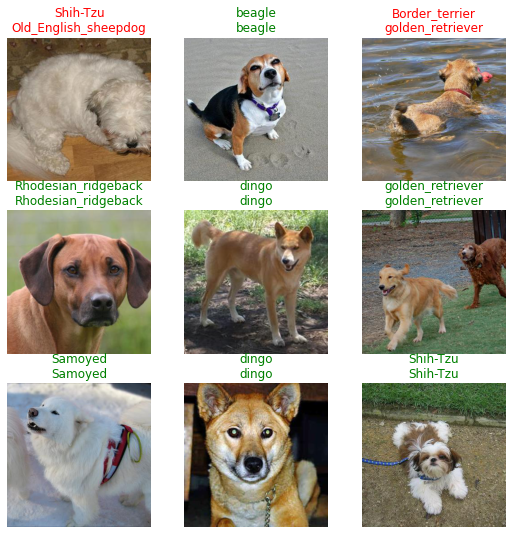

In [16]:
# show some predictions
learn.show_results()

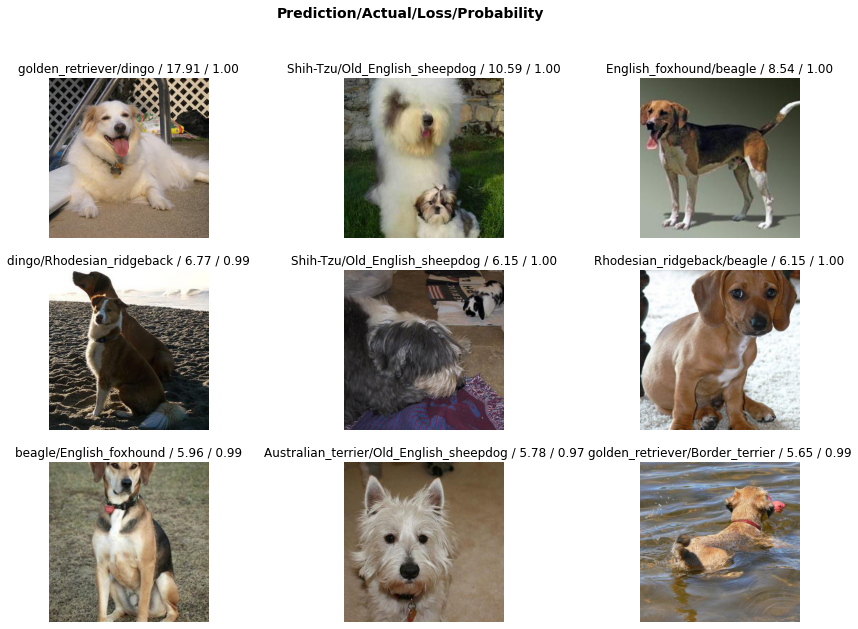

In [17]:
# show where the model is doing a bad job
interp = Interpretation.from_learner(learn)
interp.plot_top_losses(9, figsize=(15,10))

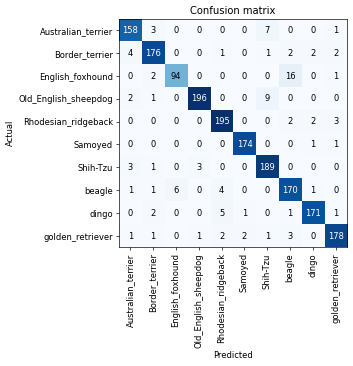

In [18]:
# disdplay a confusion matrix
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(6,6), dpi=60)